In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import pandas as pd
import cartopy.crs as ccrs
import pandas
import glob

%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
in_dir = '/home/ck/DIR/cornkle/data/nflics/core_gauge_comparison_GMet/' # directory path to inputs

In [4]:
rain = pd.read_csv(in_dir+'Axim_rr_15mins.csv', na_values='*')

In [5]:
rain['index'] = rain['Date'] + ' ' + rain['Time']

In [6]:
rain['index'] = pd.to_datetime(rain['index'], format='%m/%d/%Y %I:%M:%S %p')

In [7]:
rain = rain[['index', 'Precipitation (mm)']]
rain = rain.rename(columns={'Precipitation (mm)':'precipitation'})

In [8]:
rain['precipitation'] = rain['precipitation'].values.astype(float)

In [9]:
cores =  pd.concat( map(pd.read_csv, glob.glob(in_dir+'tables/core_stationLoc_2023*.csv')))
cores['index'] = pd.to_datetime(cores['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
cores = cores[['index', 'AXI']]
cores = cores.rename(columns={'AXI':'cores'})

In [10]:
tir =  pd.concat( map(pd.read_csv, glob.glob(in_dir+'tables/tir_stationLoc_2023*.csv')))
tir['index'] = pd.to_datetime(tir['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
tir = tir[['index', 'AXI']]
tir = tir.rename(columns={'AXI':'tir'})

In [11]:
# Merging the dataframes
merged_df = rain.merge(cores, on='index', how='outer')
merged_df = merged_df.merge(tir, on='index', how='outer')

# Sorting by timestamp if necessary
merged_df.sort_values('index', inplace=True)
merged_df = merged_df.set_index('index')

In [34]:
# calculate frequency of rainfall above a threshold 
def calc_treshReached(dat, thresh):
    
    per_bin = np.nansum(np.array(dat)>thresh)
    return per_bin/np.sum(np.isfinite(dat)), per_bin # note, probability is NaN if number of cases in bin is 0.


def threshReached_TirLoop(var1, var2, thresh, inbins):
    bins = []
    probability = []
    ns = []

    for kk in inbins:

        cc, n = calc_treshReached(var1[var2<kk], thresh)
        #print(cc, kk)
        probability.append(cc)
        bins.append(kk)
        ns.append(n)

    return {'probability' : np.array(probability), 'tir_bins' : np.array(bins), 'nb' : np.array(ns)}


def threshReached_PrecipLoop(var1, var2, thresh, inbins, gt=None, lt=None):
    bins = []
    probability = []
    ns = []

    for kk in inbins:
        
        if gt:
            cc, n = calc_treshReached(var1[var2>thresh], kk)
        elif lt:
            cc, n = calc_treshReached(var1[var2<thresh], kk)
        else:
            print('Neither gt nor lt are set. Please choose one. Stopping calculation.')
        
        probability.append(cc)
        bins.append(kk)
        ns.append(n)

    return {'probability' : np.array(probability), 'precip_bins' : np.array(bins), 'nb' : np.array(ns)}


In [35]:
# calculate fraction of retained rainfall pixels above a threshold
# Hit rate / Probability of Detection
def calc_treshRetained(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh), np.sum(np.array(dat)>thresh)  # note, probability is NaN if number of cases in bin is 0.
                                                                             

def threshRetained_PrecipLoop(var1, var2, thresh, inbins, gt=None, lt=None):
    bins = []
    probability = []
    ns = []

    for kk in inbins:
        
        if gt:
            cc, n = calc_treshRetained(var1[var2>thresh], var1, kk)
        elif lt:
            cc, n = calc_treshRetained(var1[var2<thresh], var1, kk)
        else:
            print('Neither gt nor lt are set. Please choose one. Stopping calculation.')
        
        probability.append(cc)
        bins.append(kk)
        ns.append(n)

    return {'probability' : np.array(probability), 'precip_bins' : np.array(bins), 'nb' : np.array(ns)}

In [36]:
# Threat score (Accuracy with 'correct negatives' removed from consideration - considers only forecasts that count)
# Sensitive to hits, penalises misses and false alarms.
# i.e. we are trying to maximise intense rainfall hits while minimising false alarms within the core area!

def calc_threatScore(dat, obs, thresh):
    hits_misses = np.sum(np.array(obs)>thresh)
    false_alarms = np.sum(np.array(dat)<=thresh)
    return np.sum(np.array(dat)>thresh)/ (hits_misses + false_alarms), np.sum(np.array(dat)>thresh)  # note, probability is NaN if number of cases in bin is 0.
                                                                             

def threshTS_PrecipLoop(var1, var2, thresh, inbins, gt=None, lt=None):
    bins = []
    probability = []
    ns = []

    for kk in inbins:
        
        if gt:
            cc, n = calc_threatScore(var1[var2>thresh], var1, kk)
        elif lt:
            cc, n = calc_threatScore(var1[var2<thresh], var1, kk)
        else:
            print('Neither gt nor lt are set. Please choose one. Stopping calculation.')
        
        probability.append(cc)
        bins.append(kk)
        ns.append(n)

    return {'probability' : np.array(probability), 'precip_bins' : np.array(bins), 'nb' : np.array(ns)}

In [37]:
precip_dir = threshReached_TirLoop(merged_df['precipitation'], merged_df['tir'], 5, np.arange(-90,-19,5))

/tmp/ipykernel_89348/3416469409.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return per_bin/np.sum(np.isfinite(dat)), per_bin # note, probability is NaN if number of cases in bin is 0.


In [38]:
core_dir = threshReached_TirLoop(merged_df['cores'], merged_df['tir'], 0.5, np.arange(-90,-19,5))

/tmp/ipykernel_89348/3416469409.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return per_bin/np.sum(np.isfinite(dat)), per_bin # note, probability is NaN if number of cases in bin is 0.


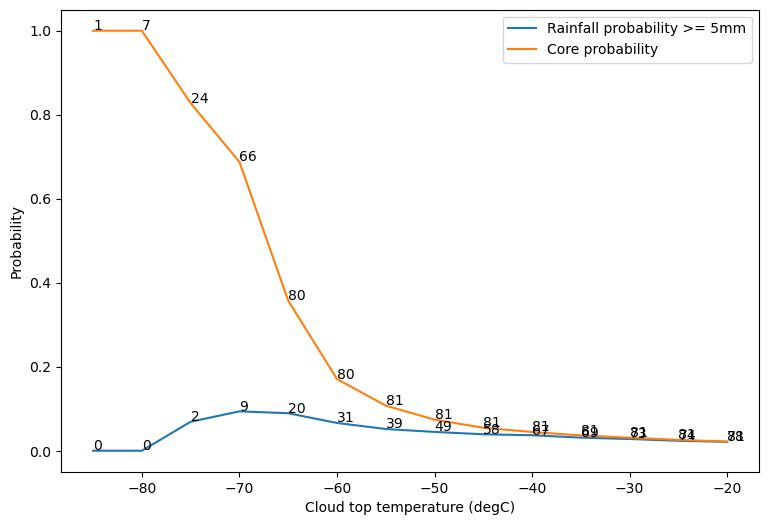

In [39]:
f = plt.figure(figsize=(9,6), dpi=100)
ax = f.add_subplot(111)

ax.plot(precip_dir['tir_bins'], precip_dir['probability'], label='Rainfall probability >= 5mm')
for tt, pp, n in zip(core_dir['tir_bins'],precip_dir['probability'],precip_dir['nb']):
    ax.text(tt, pp+0.002, str(n))

ax.plot(core_dir['tir_bins'], core_dir['probability'], label='Core probability')
for tt, pp, n in zip(core_dir['tir_bins'],core_dir['probability'],core_dir['nb']):
    ax.text(tt, pp+0.002, str(n))

ax.set_ylabel('Probability')
ax.set_xlabel('Cloud top temperature (degC)')
    
plt.legend()

In [40]:
tir_thresh = -60

allCases = threshReached_PrecipLoop(merged_df['precipitation'], merged_df['cores'], -1, np.arange(1,26,5), gt=True, lt=None)
coreCases = threshReached_PrecipLoop(merged_df['precipitation'], merged_df['cores'], 0.5, np.arange(1,26,5), gt=True, lt=None)
tirCases = threshReached_PrecipLoop(merged_df['precipitation'], merged_df['tir'],tir_thresh, np.arange(1,26,5), gt=None, lt=True)

core_retain = threshRetained_PrecipLoop(merged_df['precipitation'], merged_df['cores'], 0, np.arange(1,26,5), gt=True, lt=None)
tir_retain = threshRetained_PrecipLoop(merged_df['precipitation'], merged_df['tir'], tir_thresh, np.arange(1,26,5), gt=None, lt=True)
all_retain = threshRetained_PrecipLoop(merged_df['precipitation'], merged_df['cores'], -0.5, np.arange(1,26,5), gt=True, lt=None)

Text(0.5, 1.0, 'Difference in rainfall intensity probability (Core-TIR)')

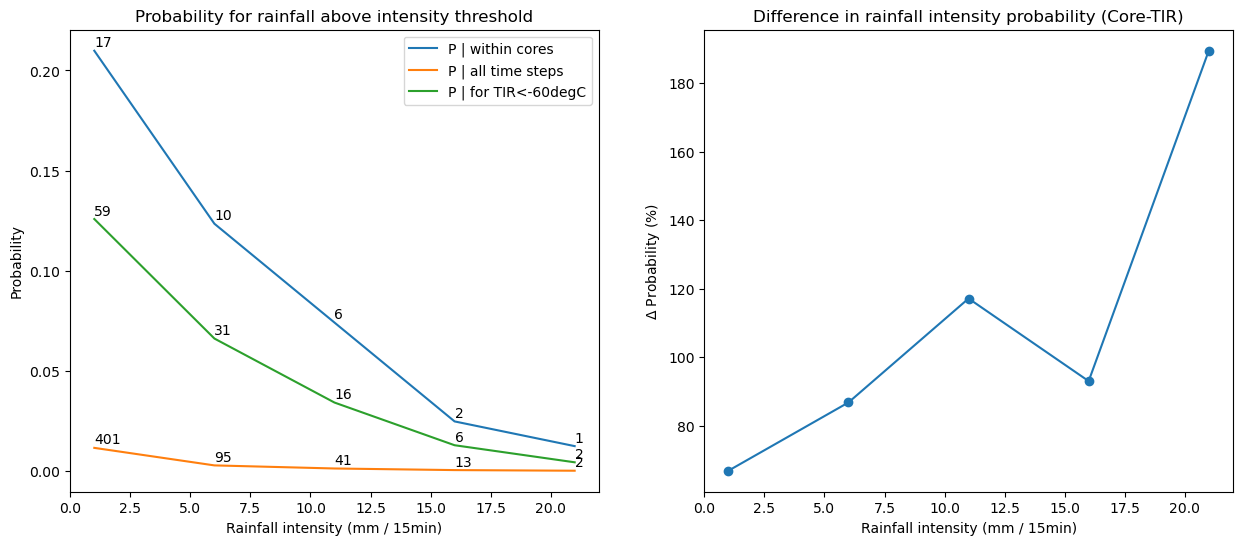

In [41]:
f = plt.figure(figsize=(15,6), dpi=100)
ax = f.add_subplot(121)

ax.plot(allCases['precip_bins'], coreCases['probability'], label='P | within cores')
for tt, pp, n in zip(allCases['precip_bins'],coreCases['probability'],coreCases['nb']):
    ax.text(tt, pp+0.002, str(n))

ax.plot(allCases['precip_bins'], allCases['probability'], label='P | all time steps')
for tt, pp, n in zip(allCases['precip_bins'],allCases['probability'],allCases['nb']):
    ax.text(tt, pp+0.002, str(n))
    
ax.plot(allCases['precip_bins'], tirCases['probability'], label='P | for TIR<'+str(tir_thresh)+'degC')
for tt, pp, n in zip(allCases['precip_bins'],tirCases['probability'],tirCases['nb']):
    ax.text(tt, pp+0.002, str(n))

ax.set_ylabel('Probability')
ax.set_xlabel('Rainfall intensity (mm / 15min)')
ax.set_title('Probability for rainfall above intensity threshold')
    
plt.legend()

ax = f.add_subplot(122)

ax.plot(allCases['precip_bins'], (coreCases['probability']-tirCases['probability'])/tirCases['probability']*100, label=r'$\Delta$P| (core-tir)/tir', marker='o')
ax.set_ylabel(r'$\Delta$ Probability (%)')
ax.set_xlabel('Rainfall intensity (mm / 15min)')
ax.set_title('Difference in rainfall intensity probability (Core-TIR)')


Text(0.5, 1.0, 'Difference in retained cases (Core-TIR)')

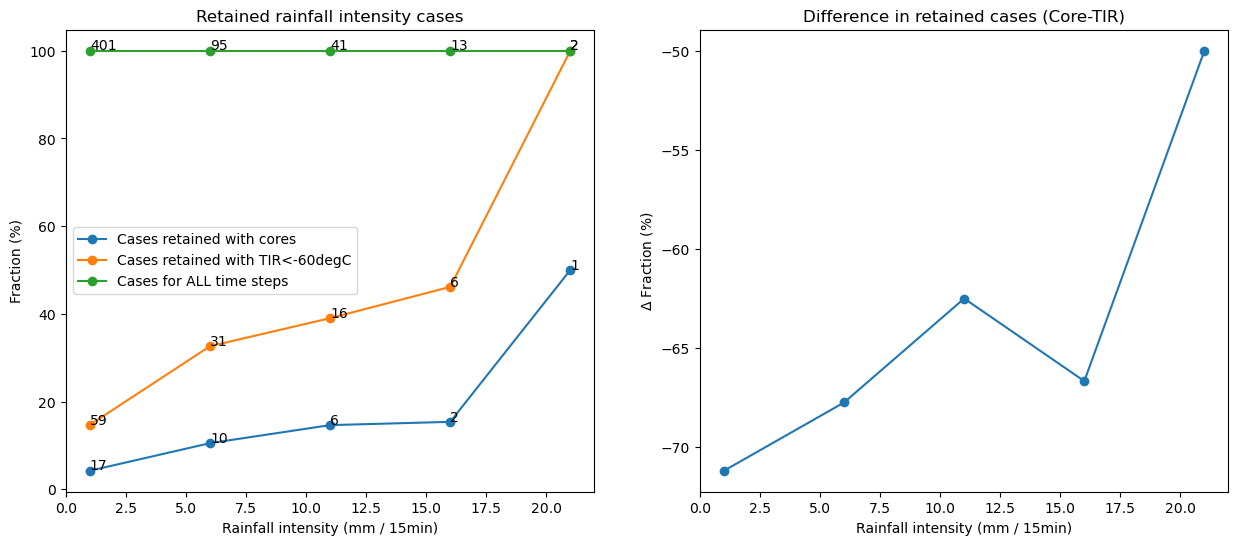

In [42]:
f = plt.figure(figsize=(15,6), dpi=100)
ax = f.add_subplot(121)

ax.plot(core_retain['precip_bins'], core_retain['probability']*100, label='Cases retained with cores', marker='o')  
ax.plot(core_retain['precip_bins'], tir_retain['probability']*100, label='Cases retained with TIR<'+str(tir_thresh)+'degC', marker='o')
ax.plot(core_retain['precip_bins'], all_retain['probability']*100, label='Cases for ALL time steps', marker='o')

ax.set_ylabel('Fraction (%)')
ax.set_xlabel('Rainfall intensity (mm / 15min)')
ax.set_title('Retained rainfall intensity cases')

for tt, pp, n in zip(core_retain['precip_bins'],core_retain['probability'],core_retain['nb']):
    ax.text(tt, (pp+0.002)*100, str(n))
    
for tt, pp, n in zip(core_retain['precip_bins'],tir_retain['probability'],tir_retain['nb']):
    ax.text(tt, (pp+0.002)*100, str(n))
    
for tt, pp, n in zip(core_retain['precip_bins'],all_retain['probability'],all_retain['nb']):
    ax.text(tt, (pp+0.002)*100, str(n))
    
    
plt.legend()
    
ax = f.add_subplot(122)

ax.plot(allCases['precip_bins'], (core_retain['probability']-tir_retain['probability'])/tir_retain['probability']*100, label=r'$\Delta$n| (core-tir)/tir', marker='o')

ax.set_ylabel(r'$\Delta$ Fraction (%)')
ax.set_xlabel('Rainfall intensity (mm / 15min)')
ax.set_title('Difference in retained cases (Core-TIR)')

Text(0.5, 1.0, 'Attempt to combine intensity probability & case retainment skill')

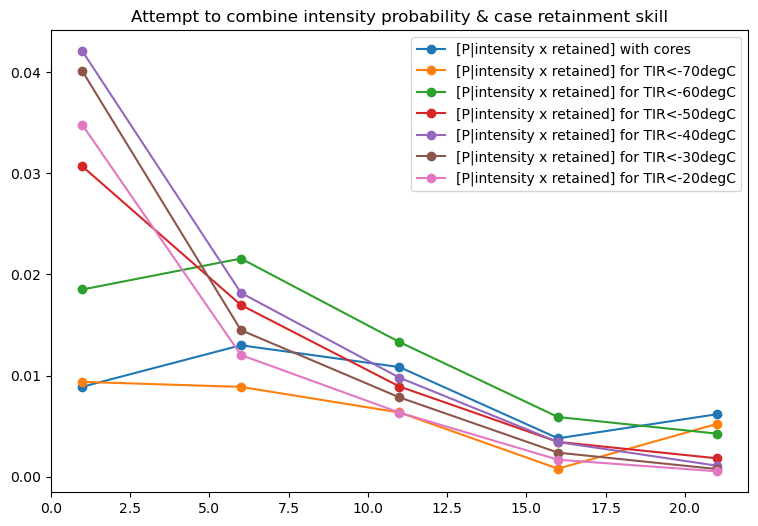

In [43]:
f = plt.figure(figsize=(9,6), dpi=100)
ax = f.add_subplot(111)

ax.plot(core_retain['precip_bins'], coreCases['probability']*core_retain['probability'], label='[P|intensity x retained] with cores', marker='o')  

for tir_thresh_vary in np.arange(-70,-15,10):
    
    tirCases_vary = threshReached_PrecipLoop(merged_df['precipitation'], merged_df['tir'],tir_thresh_vary, np.arange(1,26,5), gt=None, lt=True)
    tir_retain_vary = threshRetained_PrecipLoop(merged_df['precipitation'], merged_df['tir'], tir_thresh_vary, np.arange(1,26,5), gt=None, lt=True)


    ax.plot(core_retain['precip_bins'], tirCases_vary['probability']*tir_retain_vary['probability'], label='[P|intensity x retained] for TIR<'+str(tir_thresh_vary)+'degC', marker='o')
    
plt.legend()

plt.title('Attempt to combine intensity probability & case retainment skill')

Text(0.5, 1.0, 'Threat score [retained / retained + lost + false alarm] = accuracy without correct negatives')

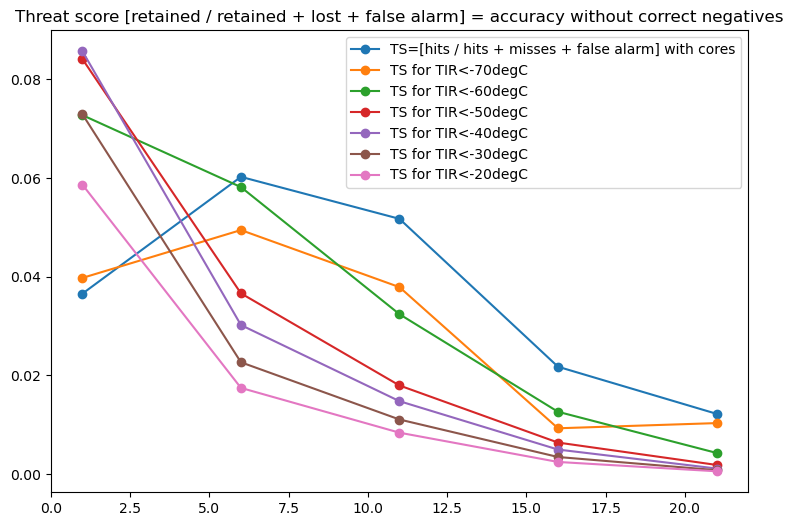

In [46]:
coreCases = threshTS_PrecipLoop(merged_df['precipitation'], merged_df['cores'], 0.5, np.arange(1,26,5), gt=True, lt=None)

f = plt.figure(figsize=(9,6), dpi=100)
ax = f.add_subplot(111)

ax.plot(core_retain['precip_bins'], coreCases['probability'], label='TS=[hits / (hits + misses + false alarm] with cores', marker='o')  

for tir_thresh_vary in np.arange(-70,-15,10):
    
    tirCases_vary = threshTS_PrecipLoop(merged_df['precipitation'], merged_df['tir'],tir_thresh_vary, np.arange(1,26,5), gt=None, lt=True)

    ax.plot(core_retain['precip_bins'], tirCases_vary['probability'], label='TS for TIR<'+str(tir_thresh_vary)+'degC', marker='o')
    
plt.legend()

plt.title('Threat score [retained / (retained + lost + false alarm)] = accuracy without correct negatives')

In [42]:
from scipy.ndimage import label

In [43]:
labels, numL = label(merged_df['cores'])

u, inv = np.unique(labels, return_inverse=True)
n = np.bincount(inv)

In [44]:
inds_1 = u[(n>=1)&(n<=2) & (u!=0)] ## at least one core timestep
inds_3 = u[(n>=3)&(n<=4)&(u!=0)] ## at least 3 core timestep
inds_5 = u[(n>=5)&(u!=0)] ## at least 5 core timestep

In [45]:
sizes = n[1::]

In [46]:
def collect_indices(inds):
    start_core_list = []
    for ids in inds:

        pos = np.where(labels==ids)[0][0]
        start_core_list.append(pos)

    start_core_pos = np.array(start_core_list)
    return start_core_list

In [47]:
start_core_1 = collect_indices(inds_1) # small cores
start_core_3 = collect_indices(inds_3) # medium cores
start_core_5 = collect_indices(inds_5) # large cores

In [48]:
val=10 # plus/minus timesteps

def collect_composite(start_core_pos, val):
    pr_composite = []
    tir_composite = []
    core_composite = []

    

    for sc in start_core_pos:
        pr = merged_df['precipitation'].iloc[sc-val:sc+val+1].values
        co = merged_df['cores'].iloc[sc-val:sc+val+1].values
        ti = merged_df['tir'].iloc[sc-val:sc+val+1].values

        if len(pr) + len(co) + len(ti) != 3*(val*2+1):
            continue

        pr_composite.append(pr)
        core_composite.append(co)
        tir_composite.append(ti)
    print(len(start_core_pos), len(pr_composite))  # check for number of excluded cases
    
    return {'pr' : np.array(pr_composite), 'core' : np.array(core_composite), 'tir' : np.array(tir_composite)}

In [49]:
small_core = collect_composite(start_core_1, val)
medium_core = collect_composite(start_core_3, val)
large_core = collect_composite(start_core_5, val)

71 70
13 13
16 16


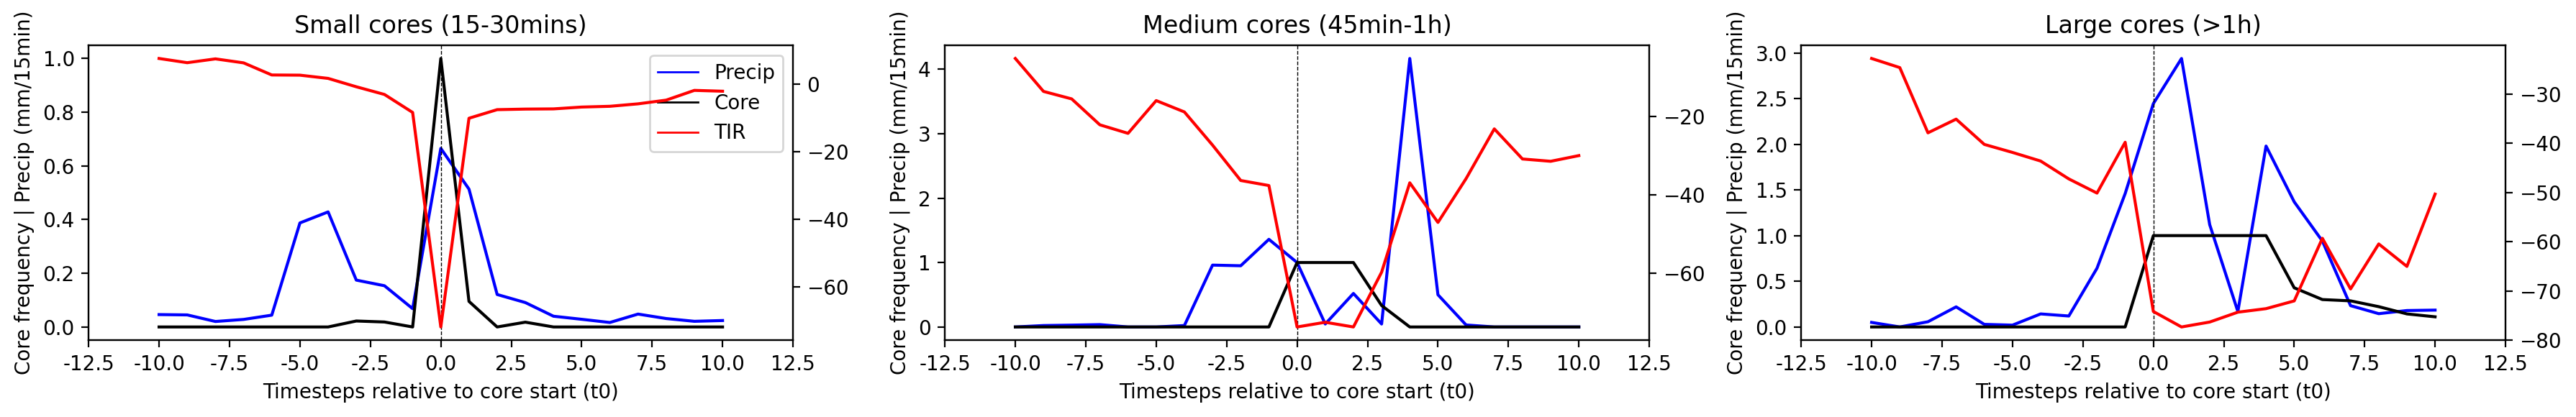

In [61]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='b', lw=1),
                Line2D([0], [0], color='k', lw=1),
                Line2D([0], [0], color='r', lw=1)]


####

f = plt.figure(figsize=(18,3), dpi=200)

tags = ['Small cores (15-30mins)', 'Medium cores (45min-1h)', 'Large cores (>1h)']

for axnb, dic in enumerate([small_core, medium_core, large_core]):
    
    ax = f.add_subplot(1,3,axnb+1)
    ax1 = ax.twinx()
    
    if axnb == 0:
        ax.legend(custom_lines, ['Precip', 'Core', 'TIR'])
    
    ax.plot(np.nanmean(dic['pr'], axis=0), color='b')
    ax.plot(np.nanmean(dic['core'], axis=0), color='k')
    ax1.plot(np.nanmean(dic['tir'], axis=0), color='r')
    
    plt.title(tags[axnb])

    locs, labs = plt.xticks()
    plt.xticks(locs,locs-val)
    
    ax.axvline(val, linewidth=0.5, color='k', linestyle='dashed')
    ax.set_xlabel('Timesteps relative to core start (t0)')
    ax.set_ylabel('Core frequency | Precip (mm/15min)')   # note, by definition core frequency at t0 = 1 (100% cores)
    


plt.tight_layout()

In [54]:
def basic_1d_binning(xvar, xbins, percentage=False):

    outdic = {}
    outdic['nb'] = []
    for issh, shl in enumerate(xbins[0:-1]):
        poss_ds = np.sum((xvar > shl) & (xvar <= xbins[issh + 1]))

        if percentage:
            divs = xvar.size
        else:
            divs = 1
        outdic['nb'].append(poss_ds/divs)
    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))
    return outdic

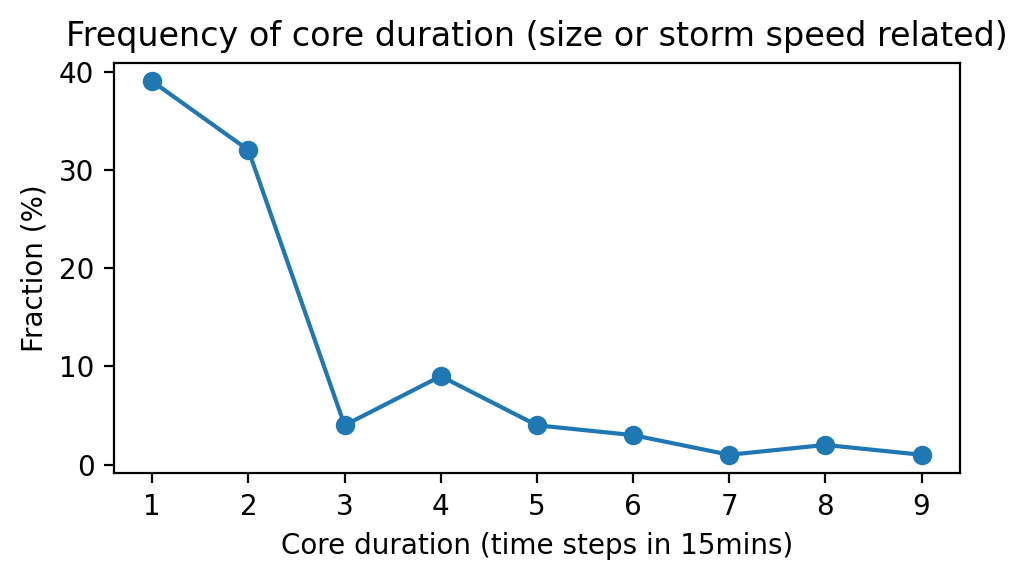

In [63]:
f = plt.figure(figsize=(5,3), dpi=200)


ax = f.add_subplot(111)

        
dic = basic_1d_binning(np.array(sizes), np.arange(0,10), percentage=True)
    
ax.plot(dic['xbins']+0.5, np.array(dic['nb'])*100, marker='o')
ax.set_ylabel('Fraction (%)')
ax.set_xlabel('Core duration (time steps in 15mins)')
plt.title('Frequency of core duration (size or storm speed related)')


plt.tight_layout()